In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
# data https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview

In [2]:
df = pd.read_csv('train.csv')

In [3]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# 1. Executive Summary/ Busienss Understanding

## Project Description from [Kaggle](www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview/evaluation)
### Goal
It is your job to predict the sales price for each house. For each Id in the test set, you must predict the value of the SalePrice variable. 

### Metric
Submissions are evaluated on Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price. (Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.)

# 2. Data Understanding

# 3. Data Preparation

## 3.1 identify missing cols

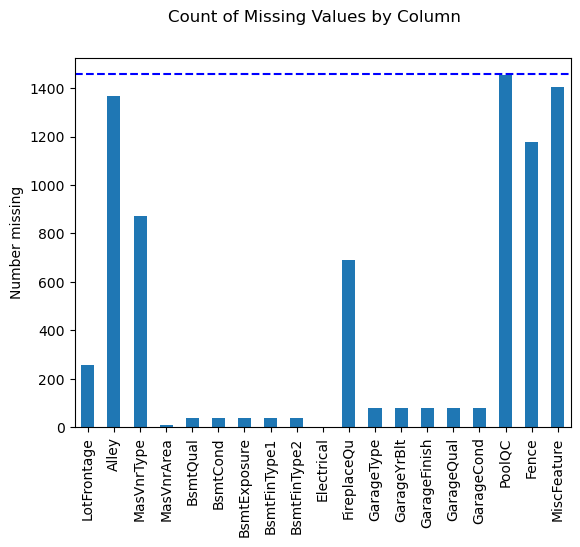

In [4]:
# identify and plot
missing_cols = df.columns[df.isna().any()].to_list()

fig, ax = plt.subplots()
df[missing_cols].isna().sum().plot.bar(ax=ax);
ax.set_ylabel('Number missing');
fig.suptitle('Count of Missing Values by Column');
plt.axhline(y = df.shape[0], color = 'b', linestyle = '--');

Drop columns missing more than 600 values

In [5]:
drop_cols = df.columns[df.isna().sum() > 600].to_list()
df.drop(columns=drop_cols, inplace = True)

## 3.2 Identify outlier rows

C:\git_repos\housing\envs\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\git_repos\housing\envs\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


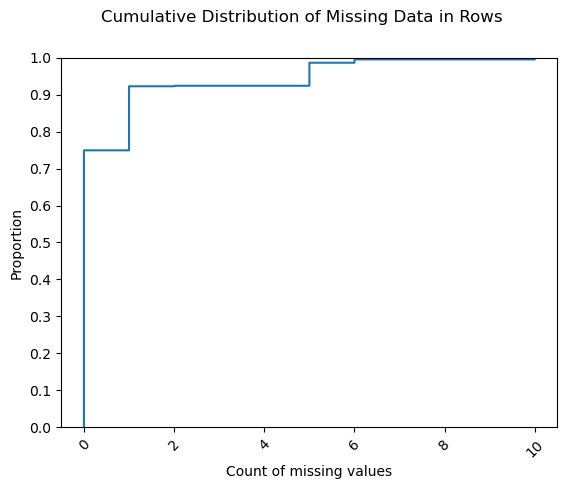

In [16]:
# identify and plot missing rows
missing_row = df.shape[1] - df.count(axis=1) # number of missing values per row

fig, ax = plt.subplots()
sns.ecdfplot(missing_row, ax=ax); 
plt.xticks(rotation=45);
ax.set_yticks(list(np.arange(0.0,1.1,0.1)));
plt.suptitle('Cumulative Distribution of Missing Data in Rows');
ax.set_xlabel('Count of missing values');

There are not many rows with lots of missing values.  Therefore these will be left as is and their values will be imputed.
The chart above shows that ~95% of rows are missings 5 or fewer values.

# 4. Modeling

# 5. Evaluation